In [2]:
import os
import time
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from datetime import datetime
from neuralop.models import FNO, FNO2d, TFNO, TFNO2d
from neuralop import Trainer
from neuralop.training import AdamW
from neuralop.data.datasets import load_darcy_flow_small
from neuralop.data.datasets.darcy import DarcyDataset
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss
import urllib.request
import scipy.io as sio

In [3]:
# Print the function signature
import inspect
print(inspect.signature(load_darcy_flow_small))

(n_train, n_tests, batch_size, test_batch_sizes, data_root=WindowsPath('c:/Users/hz283/AppData/Local/anaconda3/envs/razer/Lib/site-packages/neuralop/data/datasets/data'), test_resolutions=[16, 32], encode_input=False, encode_output=True, encoding='channel-wise', channel_dim=1)


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create a data directory if it doesn't exist
data_root = os.path.join(os.getcwd(), "data", "darcy_flow")
os.makedirs(data_root, exist_ok=True)

# Define dataset parameters:
n_train = 100                # Number of training samples (for quick demo)
n_tests = [20]               # For a single test resolution, provide as a list
batch_size = 32              # Batch size for training
test_batch_sizes = 32        # Batch size for testing

# Instantiate DarcyDataset with download=True (if not already downloaded)
dataset = DarcyDataset(
    root_dir=data_root,
    n_train=n_train,
    n_tests=n_tests,
    batch_size=batch_size,
    test_batch_sizes=test_batch_sizes,
    train_resolution=16,
    test_resolutions=[16],    # Using single test resolution
    encode_input=False,
    encode_output=True,
    encoding='channel-wise',
    channel_dim=1,
    download=True             # Attempt download if files are missing
)

print("Dataset loaded successfully.")
print("Type of train_db:", type(dataset.train_db))
# The test data are stored in a dictionary _test_dbs; list its keys:
print("Keys in _test_dbs:", list(dataset._test_dbs.keys()))

# Extract the single test database (since we only have one resolution)
test_db = list(dataset._test_dbs.values())[0]

# Create DataLoaders for training and testing
train_loader = DataLoader(dataset.train_db, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_db, batch_size=test_batch_sizes, shuffle=False, num_workers=0)

# Get a batch from the training data loader as a dictionary:
batch = next(iter(train_loader))
print("Type of batch:", type(batch))
print("Keys in batch:", batch.keys())
print("Input batch shape:", batch["x"].shape)
print("Output batch shape:", batch["y"].shape)

Loading test db for resolution 16 with 20 samples 
Dataset loaded successfully.
Type of train_db: <class 'neuralop.data.datasets.tensor_dataset.TensorDataset'>
Keys in _test_dbs: [16]
Type of batch: <class 'dict'>
Keys in batch: dict_keys(['x', 'y'])
Input batch shape: torch.Size([32, 1, 16, 16])
Output batch shape: torch.Size([32, 1, 16, 16])


c:\Users\hz283\AppData\Local\anaconda3\envs\razer\Lib\site-packages\neuralop\data\datasets\pt_dataset.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(

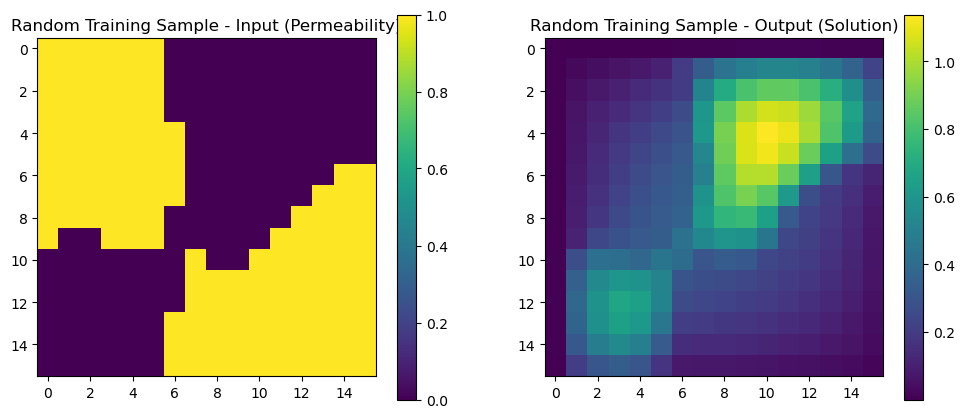

In [5]:
# Choose a random index from the training database
idx = random.randint(0, len(dataset.train_db) - 1)
sample = dataset.train_db[idx]

# Extract input and output tensors
input_tensor = sample["x"]
output_tensor = sample["y"]

# Convert tensors to numpy arrays (squeeze unnecessary dimensions)
input_np = input_tensor.squeeze().cpu().numpy()
output_np = output_tensor.squeeze().cpu().numpy()

# Plot the input and output
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(input_np, cmap='viridis')
plt.colorbar()
plt.title("Random Training Sample - Input (Permeability)")

plt.subplot(1, 2, 2)
plt.imshow(output_np, cmap='viridis')
plt.colorbar()
plt.title("Random Training Sample - Output (Solution)")

plt.show()

In [6]:
class FourierNeuralOperator(nn.Module):
    def __init__(self, modes_height, modes_width, in_channels=3, out_channels=4, hidden=32, num_layers=4):
        super(FourierNeuralOperator, self).__init__()
        self.modes_height = modes_height  # Number of Fourier modes in height dimension
        self.modes_width = modes_width  # Number of Fourier modes in width dimension
        self.hidden = hidden  # Width of the hidden channels
        self.in_channels = in_channels  # Number of input channels
        self.out_channels = out_channels  # Number of output channels
        self.num_layers = num_layers

        # FNO2d layer
        self.fno = FNO2d(in_channels=self.in_channels, out_channels=self.out_channels, n_modes_height=self.modes_height, n_modes_width=self.modes_width, hidden_channels=self.hidden, num_layers=self.num_layers)

    def forward(self, x):
        # Apply the FNO2d layer
        x = self.fno(x)
        return x

In [11]:
# Instantiate the model with desired hyperparameters
# Adjust modes and channel counts as needed; here we use arbitrary values (16 modes, in/out channels as defined)
modes_height = 16  
modes_width = 16
in_channels = 1    # change this if your data has a different number of input channels
out_channels = 1   # change this if your data has a different number of output channels
hidden = 32
num_layers = 4

model = FourierNeuralOperator(modes_height, modes_width, in_channels, out_channels, hidden, num_layers).to(device)

# Define loss function and optimizer (AdamW used here)
criterion = nn.MSELoss()

# AdamW Hyperparameters - adjust these as needed for fine-tuning:
learning_rate = 1e-1
weight_decay = 1e-4      # L2 regularization factor
#betas = (0.9, 0.999)     # Beta parameters for AdamW

# Instantiate the AdamW optimizer with separated parameters
optimizer = optim.AdamW(
    model.parameters(), 
    lr=learning_rate, 
    weight_decay=weight_decay, 
    #betas=betas
)

num_epochs = 200

Epoch 1/200 - Train Loss: 37749.9605, Test Loss: 697093.3125
Epoch 2/200 - Train Loss: 235103.7799, Test Loss: 3659023.2500
Epoch 3/200 - Train Loss: 2601774.4428, Test Loss: 111601.3750
Epoch 4/200 - Train Loss: 1306023.9950, Test Loss: 7902777.5000
Epoch 5/200 - Train Loss: 7023237.0073, Test Loss: 610.7859
Epoch 6/200 - Train Loss: 18146.1934, Test Loss: 357.7931
Epoch 7/200 - Train Loss: 918.3941, Test Loss: 2718.2827
Epoch 8/200 - Train Loss: 2543.4001, Test Loss: 2101.9478
Epoch 9/200 - Train Loss: 2869.7143, Test Loss: 3520.9824
Epoch 10/200 - Train Loss: 3557.2423, Test Loss: 1551.3051
Epoch 11/200 - Train Loss: 2801.5733, Test Loss: 2235.8599
Epoch 12/200 - Train Loss: 2102.2345, Test Loss: 1307.6541
Epoch 13/200 - Train Loss: 1103.1564, Test Loss: 452.8819
Epoch 14/200 - Train Loss: 541.6966, Test Loss: 485.7794
Epoch 15/200 - Train Loss: 441.1166, Test Loss: 315.6861
Epoch 16/200 - Train Loss: 223.1433, Test Loss: 163.8664
Epoch 17/200 - Train Loss: 170.8678, Test Loss: 134.

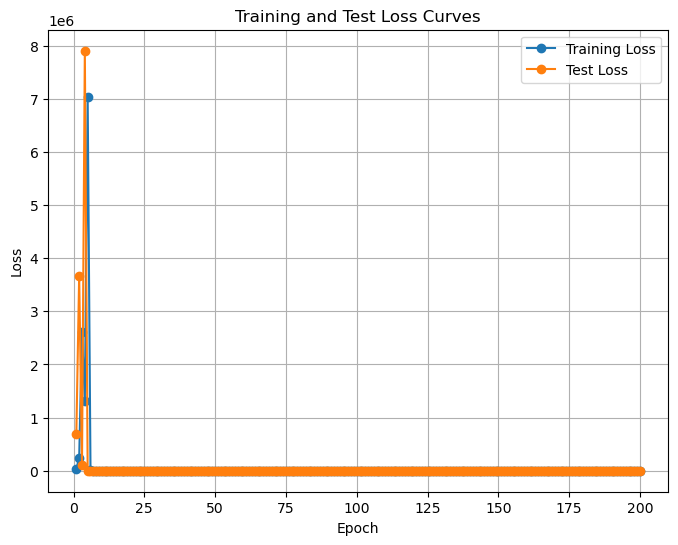

In [12]:
# Lists to store loss values
train_losses = []
test_losses = []

# Begin training
for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0
    train_sample_count = 0

    # Iterate over training batches (each batch is a dict with keys 'x' and 'y')
    for batch in train_loader:
        inputs = batch["x"].to(device)
        targets = batch["y"].to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        # Accumulate training loss and count samples
        epoch_train_loss += loss.item() * inputs.size(0)
        train_sample_count += inputs.size(0)
    
    # Average training loss for the epoch
    avg_train_loss = epoch_train_loss / train_sample_count
    train_losses.append(avg_train_loss)
    
    # Evaluate on the test set
    model.eval()
    epoch_test_loss = 0.0
    test_sample_count = 0
    with torch.no_grad():
        for batch in test_loader:
            inputs = batch["x"].to(device)
            targets = batch["y"].to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            epoch_test_loss += loss.item() * inputs.size(0)
            test_sample_count += inputs.size(0)
            
    avg_test_loss = epoch_test_loss / test_sample_count
    test_losses.append(avg_test_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

# Plot the training and test loss curves
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_losses, label="Training Loss", marker='o')
plt.plot(epochs, test_losses, label="Test Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Test Loss Curves")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
def plot_n_random_samples(n, model, test_db=None, device=torch.device("cpu")):
    """
    Plot n random test samples evaluated by the model.
    
    For each sample, three images are displayed side-by-side:
      1. Input (permeability field)
      2. Model prediction
      3. Ground truth (solution field)
    
    Parameters:
      n (int): Number of random samples to plot.
      model (nn.Module): Trained FourierNeuralOperator model.
      test_db (iterable): Optional. The test dataset. If None, it will use 
                          the first key in dataset._test_dbs.
      device (torch.device): The device used for torch tensors.
    """
    # Set the model to evaluation mode
    model.eval()
    
    # If test_db isn't provided, use the first test database from dataset._test_dbs
    if test_db is None:
        try:
            # Assuming 'dataset' has already been defined and loaded
            test_db = list(dataset._test_dbs.values())[0]
        except Exception as e:
            raise ValueError("Test database not provided and could not be extracted from dataset._test_dbs") from e

    # Prepare the figure with n rows and 3 columns
    fig, axes = plt.subplots(n, 3, figsize=(15, 5 * n))
    
    # If n==1, axes might be one-dimensional; make it two-dimensional for consistency
    if n == 1:
        axes = axes[None, :]  # add a new axis to make it 2D
    
    total_samples = len(test_db)
    # For reproducibility, optionally you could use random.sample to avoid duplicates
    sample_indices = random.sample(range(total_samples), n)
    
    with torch.no_grad():
        for i, idx in enumerate(sample_indices):
            sample = test_db[idx]
            input_tensor = sample["x"]
            target_tensor = sample["y"]

            # Add a batch dimension (if needed) and move to device for evaluation
            input_tensor_expanded = input_tensor.unsqueeze(0).to(device)
            prediction_tensor = model(input_tensor_expanded)

            # Squeeze back to remove batch dimension and convert to NumPy
            input_image = input_tensor.squeeze().cpu().numpy()
            prediction_image = prediction_tensor.squeeze().cpu().numpy()
            target_image = target_tensor.squeeze().cpu().numpy()
            
            # Plot Input
            ax = axes[i, 0]
            im0 = ax.imshow(input_image, cmap='viridis')
            ax.set_title("Input (Permeability)")
            fig.colorbar(im0, ax=ax)
            
            # Plot Prediction
            ax = axes[i, 1]
            im1 = ax.imshow(prediction_image, cmap='viridis')
            ax.set_title("Model Prediction")
            fig.colorbar(im1, ax=ax)
            
            # Plot Ground Truth
            ax = axes[i, 2]
            im2 = ax.imshow(target_image, cmap='viridis')
            ax.set_title("Ground Truth")
            fig.colorbar(im2, ax=ax)
    
    plt.tight_layout()
    plt.show()

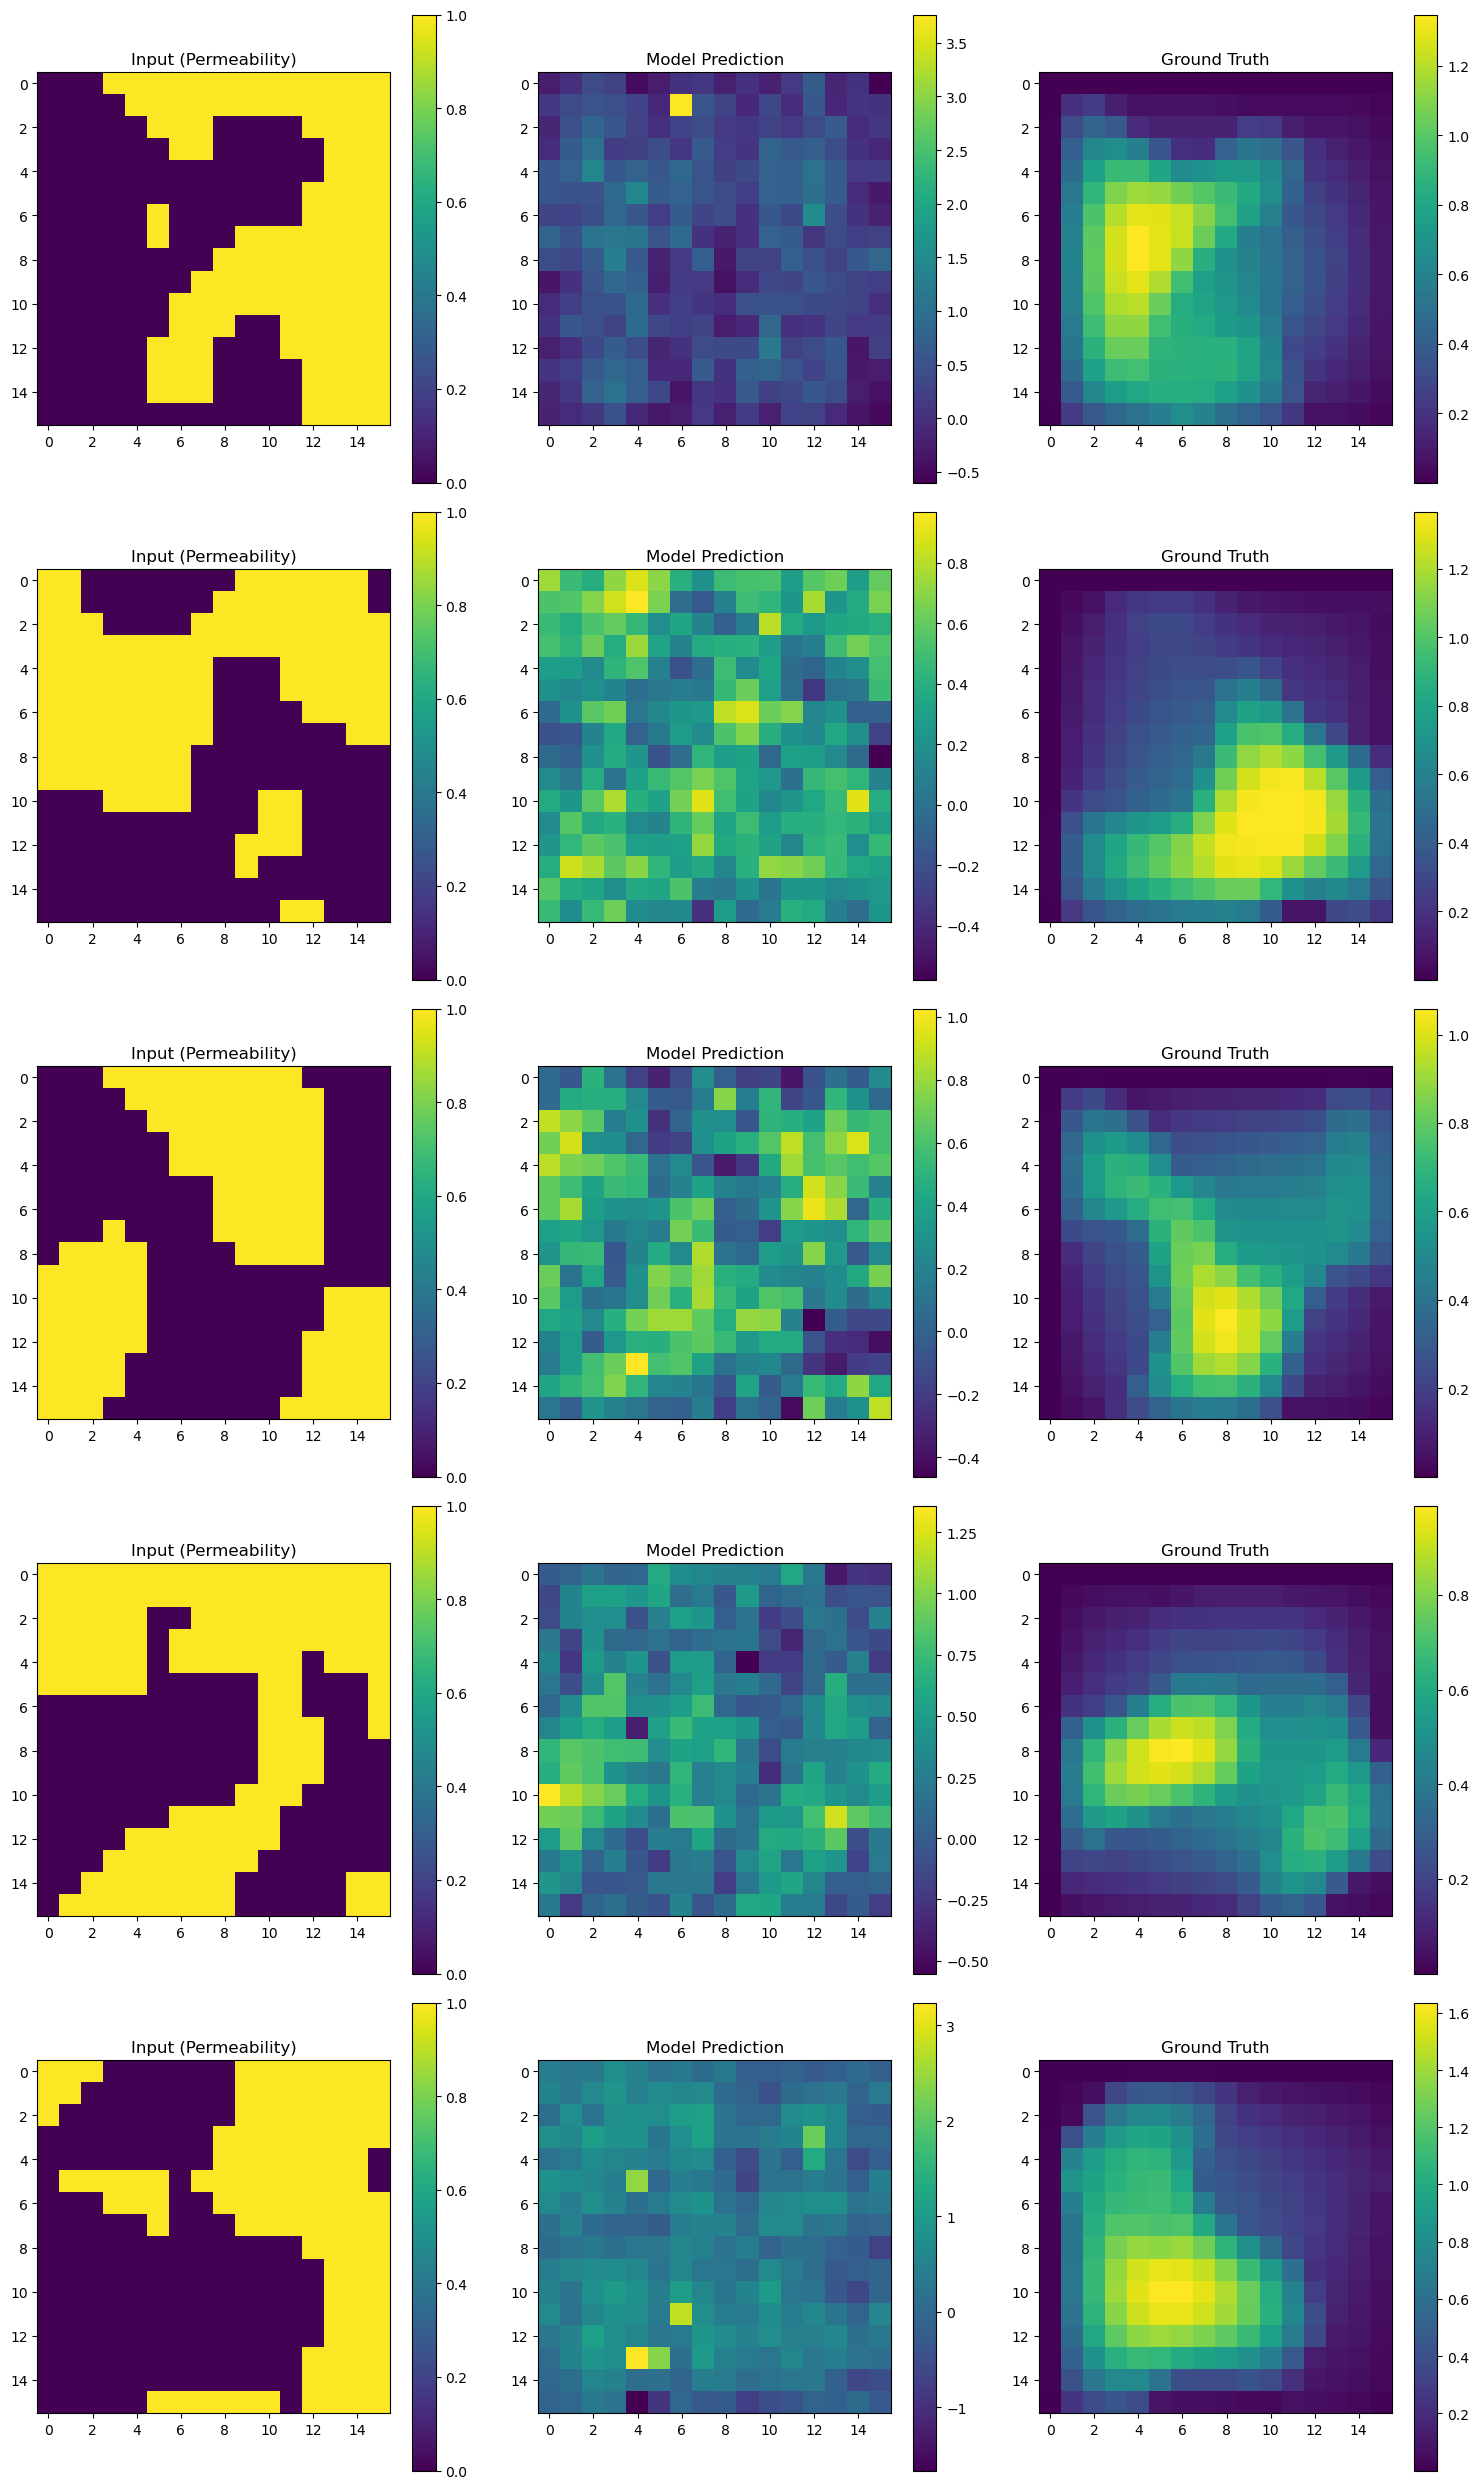

In [14]:
plot_n_random_samples(5, model, device=device)